# Run ensemble model and submit predictions

### Imports

In [1]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('../..')  # change to main directory
print('Working directory:', os.getcwd())

Working directory: c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\adrian_sensorium


In [2]:
from sensorium.utility.training import read_config
from sensorium.utility import submission
from nnfabrik.builder import get_data, get_model, get_trainer
import torch

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.auto import tqdm


import warnings

warnings.filterwarnings('ignore')

### Load configuration for model

In [3]:
# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'notebooks/submission_m4/config_m4_ens0.yaml'
config = read_config(config_file)
print(config)

{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh': True}, 'init_sigma': 0.14, 'init_mu_range': 0.8, 'gauss_type': 'full', 'shifter': True, 'with_modulator': True, 'modulator_type': 'HistoryStateGain', 'm

### Prepare dataloader

In [4]:
# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = "notebooks/data/IM_prezipped"
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
folders

['notebooks/data/IM_prezipped/LPE11086/2023_12_16']

In [5]:
folders = [ 'notebooks/data/IM_prezipped/LPE11086/2023_12_16']

dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

### Load trained models

In [6]:
# Instantiate all five models
model_list = list()

for i in tqdm(range(5)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

### Combine them into one ensemble model

In [7]:
from sensorium.models.ensemble import EnsemblePrediction

In [8]:
ensemble = EnsemblePrediction(model_list, mode='mean')

In [9]:
type(model_list[0])

neuralpredictors.layers.encoders.firing_rate.ModulatedFiringRateEncoder

### Generate submission file

In [10]:
# dataset_name = '27204-5-13'

# submission.generate_submission_file(trained_model=ensemble, 
#                                     dataloaders=dataloaders,
#                                     data_key=dataset_name,
#                                     path="notebooks/submission_m4/results/",
#                                     device="cuda")

### Evaluate model on all datasets

In [11]:
from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

#### Test data

In [12]:
single_trial_correlation = get_correlations(
    ensemble, dataloaders, tier="test", device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                       measure_attribute="Single Trial Correlation"
                       )

In [13]:
for k in dataloaders['test']:
    assert len(df[df['dataset'] == k]) == len(dataloaders['test'][k].dataset.neurons.area), "Length of df and dataloader not equal"
    df.loc[df['dataset'] == k, 'area'] = dataloaders['test'][k].dataset.neurons.area

In [14]:
%matplotlib inline

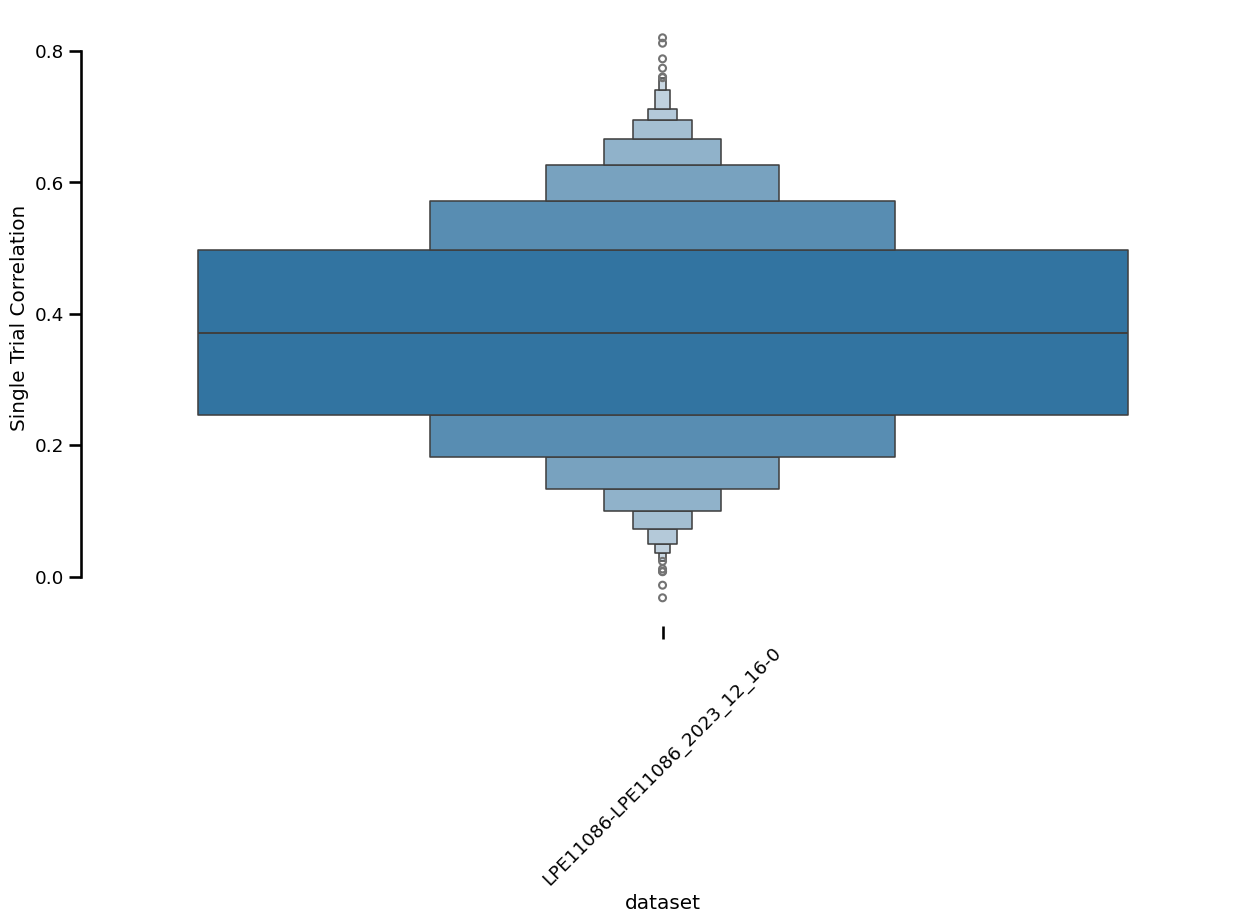

In [15]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15, 8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation=45)
sns.despine(trim=True)

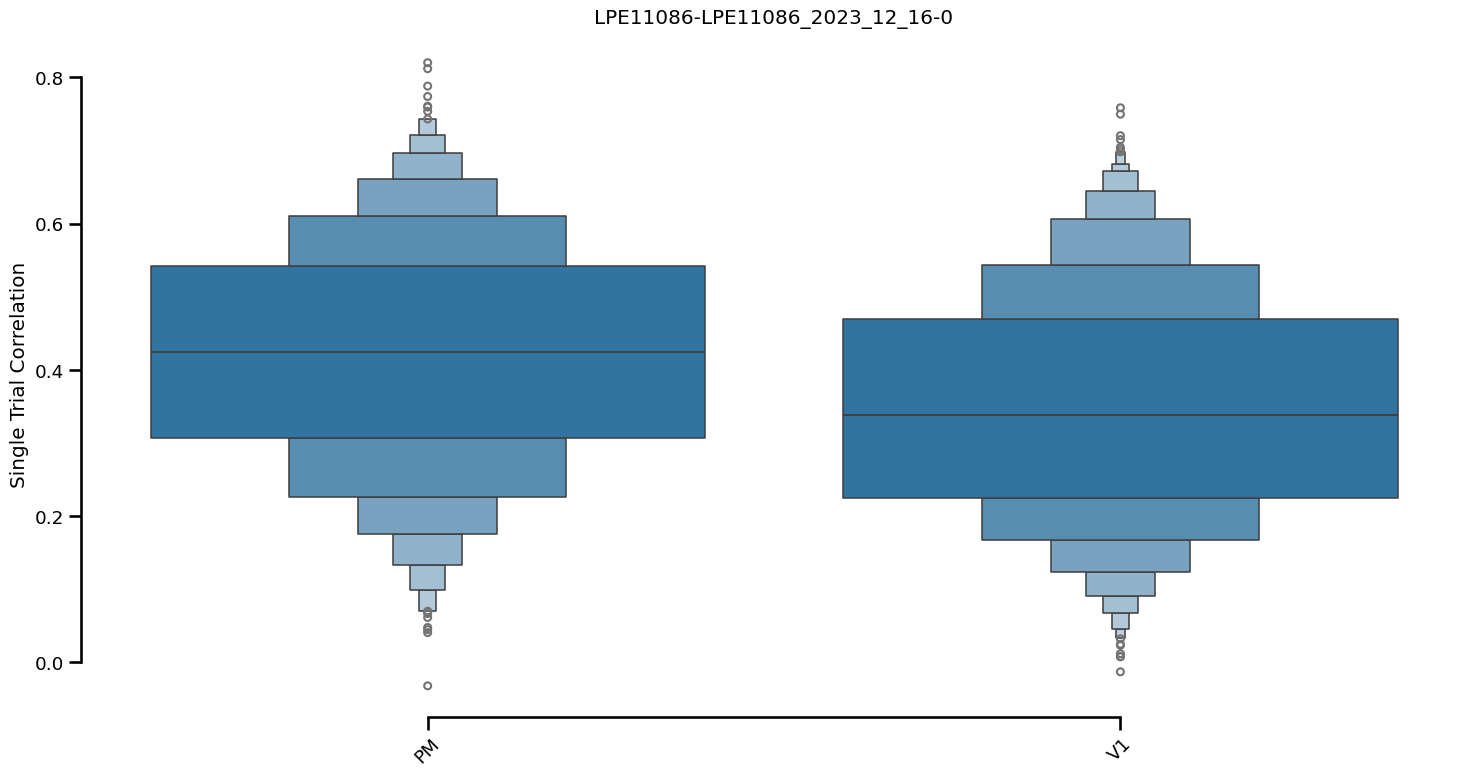

In [73]:
sns.set_context("talk", font_scale=.8)
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for idx, (ax, (i, g)) in enumerate(zip(np.array(axes).reshape(-1), df.groupby('dataset'))):
    sns.boxenplot(x="area", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

    if idx > 0:
        # remove y axis line
        ax.spines['left'].set_visible(False)
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.get_yaxis().set_visible(False)

        for spine in ax.spines.values():
            spine.set_visible(False)            

sns.despine(trim=True)
plt.tight_layout()
plt.show()

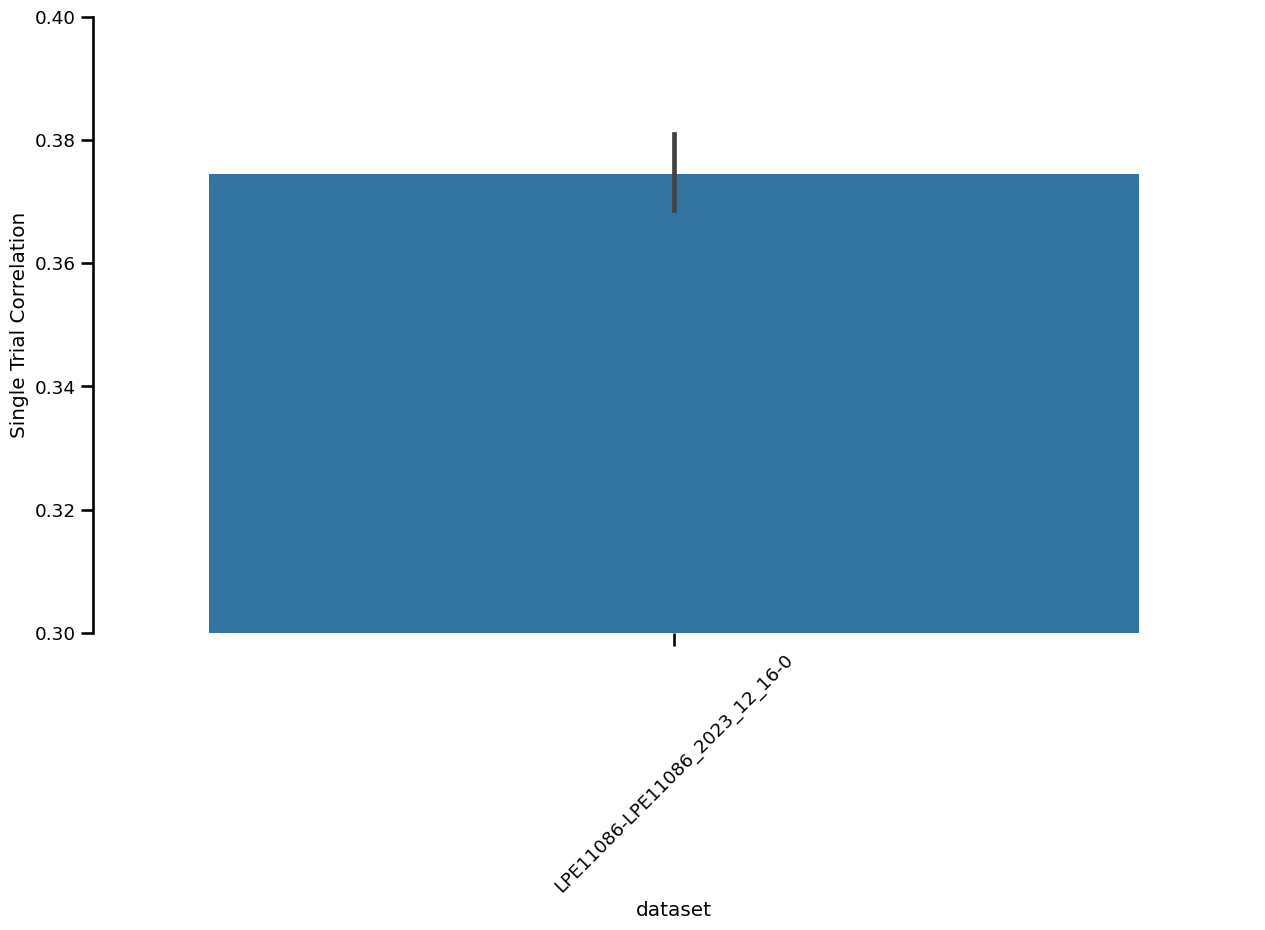

In [18]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15, 8))
sns.barplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation=45)
plt.ylim(0.3, 0.4)
sns.despine(trim=True)

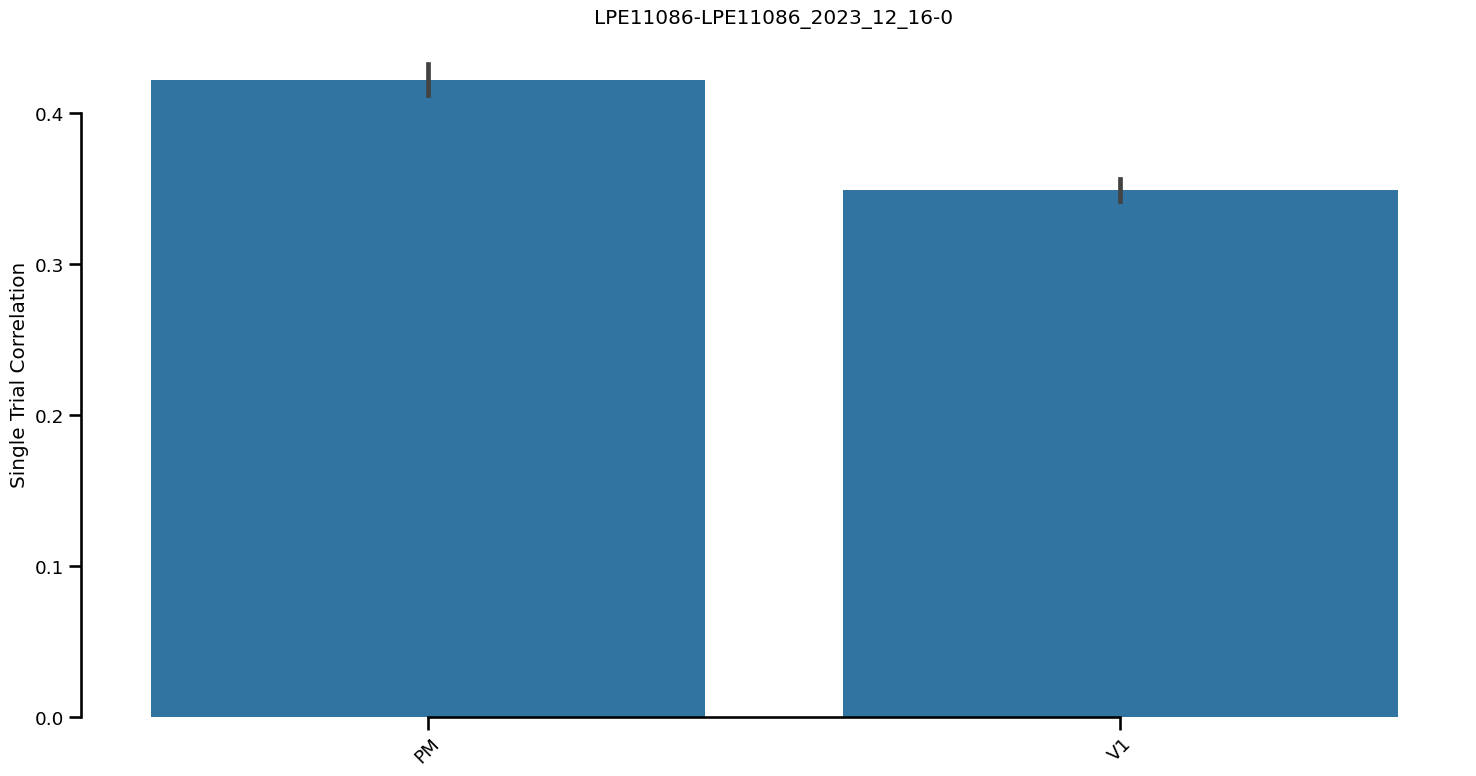

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for ax, (i, g) in zip(np.array(axes).reshape(-1), df.groupby('dataset')):
    sns.barplot(x="area", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

In [16]:
df.groupby('dataset').describe()

Single Trial Correlation                      \
                                                  count      mean       std   
dataset                                                                       
LPE11086-LPE11086_2023_12_16-0                   2585.0  0.374555  0.160749   

                                                                        \
                                     min       25%       50%       75%   
dataset                                                                  
LPE11086-LPE11086_2023_12_16-0 -0.032151  0.246515  0.370967  0.497009   

                                         
                                    max  
dataset                                  
LPE11086-LPE11086_2023_12_16-0  0.81994